In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import copy
import datetime as dt
import pandas as pd
import numpy as np

In [2]:
X, y = make_moons(n_samples=150, random_state=33, noise=0.2)

In [3]:
df = pd.DataFrame(X, columns=['x1', 'x2'])
df['target'] = y
df.head(5)

,x1,x2,target
0,0.528470,-0.353776,1
1,-0.968172,0.134251,0
2,0.030177,0.961802,0
3,-0.463210,0.997252,0
4,1.854772,0.152242,1


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=33)

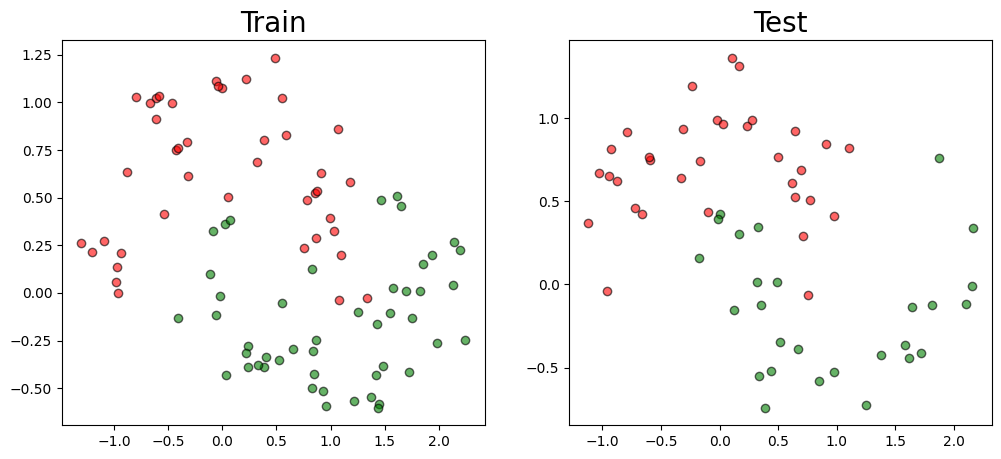

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.scatter(X_train[:,0][y_train == 0], X_train[:,1][y_train == 0], c='red', marker='o', edgecolors = 'black', alpha = 0.6)
ax1.scatter(X_train[:,0][y_train == 1], X_train[:,1][y_train == 1], c='green', marker = 'o', edgecolors = 'black', alpha = 0.6)
ax1.set_title('Train', fontsize=20)

ax2.scatter(X_test[:,0][y_test == 0], X_test[:,1][y_test == 0], c='red', marker='o', edgecolors = 'black', alpha = 0.6)
ax2.scatter(X_test[:,0][y_test == 1], X_test[:,1][y_test == 1], c='green', marker = 'o', edgecolors = 'black', alpha = 0.6)
ax2.set_title('Test', fontsize=20);

In [6]:
class MyDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

In [7]:
import torch.nn as nn

ReLU = nn.ReLU()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = ReLU(self.fc1(x))
        x = ReLU(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x.view(-1)

In [8]:
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)


In [9]:
class Trainer():
    """
    Parameters:
        dataset: пользовательский класс, предобрабатывающий данные
        loss_f: функция потерь
        learning_rate: величина градиентного шага
        epoch_amount: общее количество эпох
        batch_size: размер одного бача
        max_batches_per_epoch: максимальное количество бачей, 
                               подаваемых в модель в одну эпоху
        device: устройство для вычислений
        early_stopping: количество эпох без улучшений до остановки обучения
        optim: оптимизатор
        scheduler: регулятор градиентного шага
        permutate: перемешивание тренировочной выборки перед обучением

    Attributes:
        start_model: необученная модель
        best_model: модель, после обучения
        train_loss: средние значения функции потерь на тренировочных 
                    данных в каждой эпохе
        val_loss: средние значения функции потерь на валидационных 
                  данных в каждой эпохе

    Methods:
        fit: обучение модели
        predict: возвращает предсказание обученной моделью

    """
    def __init__(self,  dataset, net, loss_f, learning_rate=1e-3,
                 epoch_amount=10, batch_size=12,
                 max_batches_per_epoch=None,
                 device='cpu', early_stopping=10,
                 optim=torch.optim.Adam,
                 scheduler=None, permutate=True):

        self.loss_f = loss_f
        self.learning_rate = learning_rate
        self.epoch_amount = epoch_amount
        self.batch_size = batch_size
        self.max_batches_per_epoch = max_batches_per_epoch
        self.device = device
        self.early_stopping = early_stopping
        self.optim = optim
        self.scheduler = scheduler
        self.permutate = permutate
        self.dataset = dataset
        self.start_model = net
        self.best_model = net

        self.train_loss = []
        self.val_loss = []

    def predict(self, X):
        return self.best_model(X)

    def fit(self, X_train, X_test, y_train, y_test):

        Net = self.start_model

        device = torch.device(self.device)

        Net.to(self.device)

        optimizer = self.optim(Net.parameters(), lr=self.learning_rate)

        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer)

        train = self.dataset(X_train, y_train)
        val = self.dataset(X_test, y_test)

        train = DataLoader(train, batch_size=self.batch_size, shuffle=self.permutate)
        val = DataLoader(val, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf') # Лучшее значение функции потерь на валидационной выборке
        # функции потерь на валидационной выборке
        best_ep = 0                  # Эпоха, на которой достигалось лучшее 
        # значение функции потерь на валидационной выборке

        for epoch in range(self.epoch_amount):
            start = dt.datetime.now()
            print(f'Эпоха: {epoch}', end=' ')
            Net.train()
            mean_loss = 0
            batch_n = 0

            for batch_X, target in train:
                if self.max_batches_per_epoch is not None:
                    if batch_n >= self.max_batches_per_epoch:
                        break
                optimizer.zero_grad()

                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)
                loss.backward()
                optimizer.step()

                mean_loss += float(loss)
                batch_n += 1

            mean_loss /= batch_n
            self.train_loss.append(mean_loss)
            print(f'Loss_train: {mean_loss}, {dt.datetime.now() - start} сек')

            Net.eval()
            mean_loss = 0
            batch_n = 0

            with torch.no_grad():
                for batch_X, target in val:
                    if self.max_batches_per_epoch is not None:
                        if batch_n >= self.max_batches_per_epoch:
                            break
                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)

                mean_loss += float(loss)
                batch_n += 1

            mean_loss /= batch_n
            self.val_loss.append(mean_loss)
            print(f'Loss_val: {mean_loss}')

            if mean_loss < best_val_loss:
                self.best_model = Net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()
            print()

In [10]:
params = {
    'dataset': MyDataset,
    'net': net,
    'epoch_amount': 1000,
    'learning_rate': 1e-2,
    'early_stopping': 25,
    'loss_f': nn.BCELoss(),
    'optim': torch.optim.SGD,
}

clf = Trainer(**params)
clf.fit(X_train, X_test, y_train, y_test)

Эпоха: 0 Loss_train: 0.6894621178507805, 0:00:00.049279 сек
Loss_val: 0.6656695008277893

Эпоха: 1 Loss_train: 0.6858128756284714, 0:00:00.001382 сек
Loss_val: 0.6643896102905273

Эпоха: 2 Loss_train: 0.6848618984222412, 0:00:00.001341 сек
Loss_val: 0.6635872721672058

Эпоха: 3 Loss_train: 0.6791543588042259, 0:00:00.001350 сек
Loss_val: 0.6623595952987671

Эпоха: 4 Loss_train: 0.6762754991650581, 0:00:00.001317 сек
Loss_val: 0.6616010665893555

Эпоха: 5 Loss_train: 0.671677403151989, 0:00:00.001336 сек
Loss_val: 0.6601794362068176

Эпоха: 6 Loss_train: 0.6667708680033684, 0:00:00.001932 сек
Loss_val: 0.6587662696838379

Эпоха: 7 Loss_train: 0.6655574813485146, 0:00:00.001482 сек
Loss_val: 0.6573556065559387

Эпоха: 8 Loss_train: 0.6604837998747826, 0:00:00.001437 сек
Loss_val: 0.6552451252937317

Эпоха: 9 Loss_train: 0.6571895629167557, 0:00:00.001477 сек
Loss_val: 0.6539857387542725

Эпоха: 10 Loss_train: 0.6522900834679604, 0:00:00.001420 сек
Loss_val: 0.6522395014762878

Эпоха: 11 

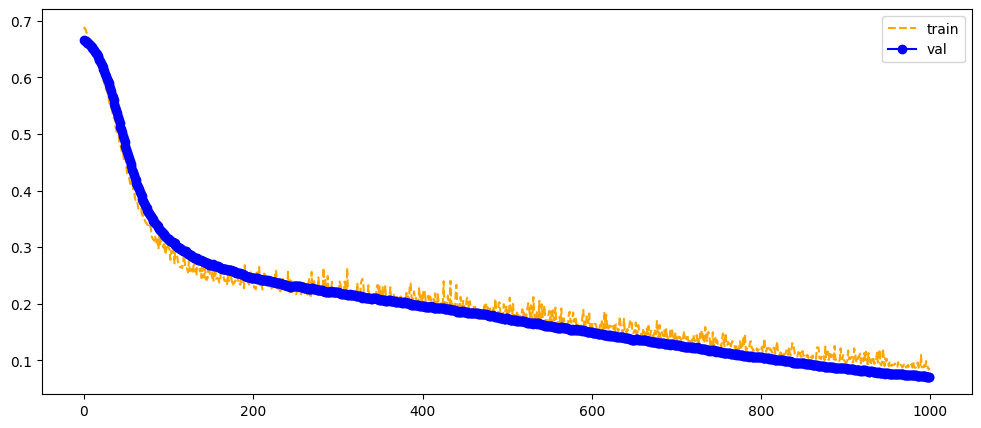

In [11]:
def plot_loss(Loss_train, Loss_val):
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(Loss_train)), Loss_train, color='orange', label='train', linestyle='--')
    plt.plot(range(len(Loss_val)), Loss_val, color='blue', marker='o', label='val')
    plt.legend()
    plt.show()

plot_loss(clf.train_loss, clf.val_loss)

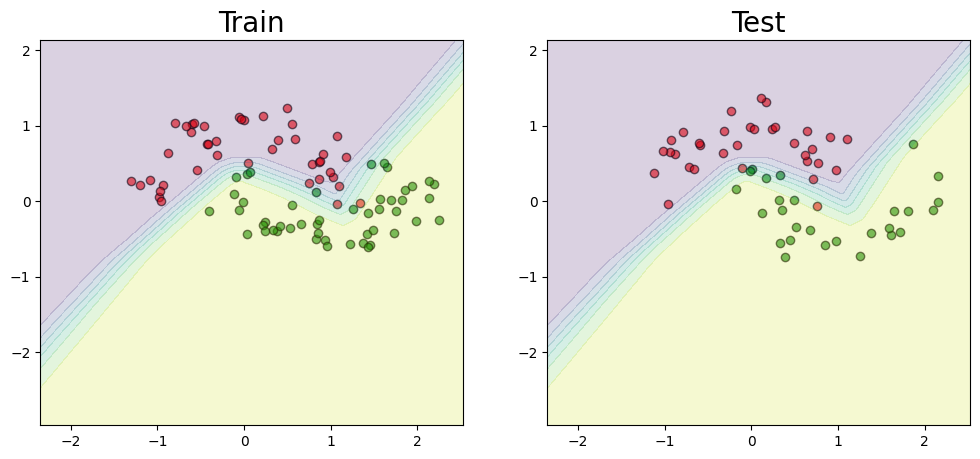

In [12]:
def make_meshgrid(x1, x2, h=.02):
    x1_min, x1_max = x1.min() - 2, x1.max() + 2
    x2_min, x2_max = x2.min() - 2, x2.max() + 2
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    return xx1, xx2

def plot_contours(ax, xx1, xx2, **params):
    C = clf.predict(torch.Tensor(np.c_[xx1.ravel(), xx2.ravel()])).detach().numpy()
    C = C.reshape(xx1.shape)
    out = ax.contourf(xx1, xx2, C, **params)
    return out

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

xx1, xx2 = make_meshgrid(X[0], X[1])

ax1.scatter(X_train[:,0][y_train == 0], X_train[:,1][y_train == 0], c='red', marker='o', edgecolors = 'black', alpha = 0.6)
ax1.scatter(X_train[:,0][y_train == 1], X_train[:,1][y_train == 1], c='green', marker = 'o', edgecolors = 'black', alpha = 0.6)
ax1.set_title('Train', fontsize=20)
plot_contours(ax1, xx1, xx2, alpha=0.2)

ax2.scatter(X_test[:,0][y_test == 0], X_test[:,1][y_test == 0], c='red', marker='o', edgecolors = 'black', alpha = 0.6)
ax2.scatter(X_test[:,0][y_test == 1], X_test[:,1][y_test == 1], c='green', marker = 'o', edgecolors = 'black', alpha = 0.6)
ax2.set_title('Test', fontsize=20)
plot_contours(ax2, xx1, xx2, alpha=0.2);